In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import credentials
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import datetime as dt


#pulling data API

key =credentials.login['key_isaham']  # extract password

In [2]:
def strategy_label(wl, add_features = "False"):
    
    ori_data = {}
    all_ori_stocks = []
    # Scale dictionary of dataframes for training set(scaling by stock)
    ss={}
    d = {}

    # Scale dictionary of dataframes for prediction set(scaling by stock)
    sp={}
    nsp={}

    for m,stock in enumerate (wl):

        #print("----------------PROCESSING {}------------------".format(stock))
        symbol = stock    # Which stock to pull    
        response = requests.get("https://admin.isaham.my/api/chart?stock={}&key={}".format(symbol,key))
        data = response.json()
        
        if data['status'] != 'Stock not found.':
            ori = pd.DataFrame.from_dict(data)
            ori = ori[['c','d','h','l','o','v']]

            if sum(ori["v"].tail(5))> 1:
                ori['d'] = pd.to_datetime(ori['d'], dayfirst= True )
                # adding the stock names
                ori["Stock"] = stock
                ori_data[f"{symbol}"] = ori
                all_ori_stocks.append(ori_data[stock])

                df = ori.reset_index(drop=False)

                if add_features == "True":
                    # Adding features
                    # MA5 & MA20
                    ff.MA(df, "c", 5)
                    ff.MA(df, "c", 20)
                    # VMA5 & VMA20
                    ff.MA(df, "v", 5)
                    ff.MA(df, "v", 20)
                    # Croses signal
                    # MAs
                    ff.cross_detection(df, "VMA5", "VMA20")
                    # VMAs
                    ff.cross_detection(df, "VMA5", "VMA20")
                    # others
                    # volatility
                    ff.volatility(df)
                    # Momentum
                    ff.momentum(df, "c", 14)
                    # date labels
                    ff.date_labels(df)

                # Tuning OB and OS level
                ob_cross=85
                os_cross=35

                # Identify MA50
                n=50
                ma50=[] 

                for i in range(len(df["c"])-(n-1)):
                    ma = round(sum(df["c"][i:i+(n)])/n,4)
                    ma50.append(ma)

                df["MA50"] = pd.Series(ma50)
                df["MA50"] = df["MA50"].shift(n-1)

                # Filter uptrend price above ma50
                # Calculating the gap of both MA
                df["MAgap"] = df["c"] -  df["MA50"] 

                # Set date as index
                df.set_index('d',inplace=True,drop=False)
                df.index.name = None

                # Create signal for uptrend price above ma50 
                # Result not accurate for stochastic when just filter uptrend only
                df["Uptrend"]=df['MAgap']>0
                Uptrend=df["Uptrend"]
                Uptrend_signal=Uptrend[Uptrend==True]

                # Signal stochastic
                # Create the "L14" column in the DataFrame
                df['L14'] = df['l'].rolling(window=14).min()

                # Create the "H14" column in the DataFrame
                df['H14'] = df['h'].rolling(window=14).max()

                # Create the "%K" column in the DataFrame
                df['%K'] = 100*((df['c'] - df['L14']) / (df['H14'] - df['L14']) )

                # Create the "%D" column in the DataFrame
                df['%D'] = df['%K'].rolling(window=3).mean()

                # Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
                # A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
                df['Buy OS'] = ((df['%K'] > df['%D']) & (
                    df['%K'].shift(1) < df['%D'].shift(1))) & (
                    df['%D'] < os_cross) & (
                    Uptrend_signal)

                # Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
                # A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
                df['Sell OB'] = ((df['%K'] < df['%D']) & (
                    df['%K'].shift(1) > df['%D'].shift(1))) & (
                    df['%D'] > ob_cross) 

                # Create a column in the DataFrame for name of stock
                df['Stock_Name'] = symbol

                df.index.names = ['Buy_Date']

                # Define overbought and oversold
                overbought = df['Sell OB']
                oversold = df['Buy OS']

                # Use index(date) for create strategy using overbought and oversold
                date_os = list(oversold[oversold == True].index)
                date_ob = list(overbought[overbought == True].index)

                # Scaling certain features only
                col_names_pred = ['c', 'l', 'o', 'v','h']

                if add_features == "True":
                    col_names_pred = col_names_pred + ["MA5", "MA20", "MA50", "MAgap", 'VMA5', 'VMA20','STD', 'rsi']

                features_pred = df[col_names_pred]

                # Scaling for prediction data
                scaler_pred = StandardScaler().fit(features_pred.values)
                features_pred = scaler_pred.transform(features_pred.values)

                # Convert the array back to a dataframe
                dataset_pred = DataFrame(features_pred)

                # Prepare prediction data that no need to scale
                col_notscale_pred = ['d','Stock_Name','Buy OS']

                if add_features == "True":
                    col_notscale_pred = col_notscale_pred + ['VMA5xVMA20', 'price_dev', 'Mom',
                                                   'Y', 'MoY', 'WoM', 'WoY', 'DoY', 'DoM', 'DoW']

                features_notscale_pred = df[col_notscale_pred]

                # Saving in multiple variable
                sp["{}".format(stock)] = dataset_pred
                nsp["{}".format(stock)] = features_notscale_pred

                # Transaction recording
                buy = []
                sell = []
                sdate = []
                bdate = []
                wr = []
                pct = []
                vol = []
                ope =[]
                high = []
                low = []

                # Record close,open,vol,high,low for buy transaction
                for n,i in enumerate(date_os):
                    buy.append(df['c'].loc[i])
                    vol.append(df['v'].loc[i])
                    ope.append(df['o'].loc[i])
                    high.append(df['h'].loc[i])
                    low.append(df['l'].loc[i])
                    bdate.append(i)
                    r=[]

                    for m,k in enumerate(date_ob):

                        if k>i:
                            r.append(m)
                            if len(r) ==1:
                                # Record close,percentage change for sell transaction
                                sell.append(df['c'].loc[k])
                                sdate.append(k)
                                pct_change=((df['c'].loc[k]/df['c'].loc[i])-1)*100
                                pct.append(((df['c'].loc[k]/df['c'].loc[i])-1)*100)
                            elif len(r)>1:
                                pass

                diff =len(buy)-len(sell)
                # Checking for final transaction, make sure it is sell, as we want to close the position
                if len(buy) == len(sell):
                    pass   
                elif len(buy) != len(sell):
                    # Deleting excess buy transaction after we close position
                    del(buy[-diff:])
                    del(bdate[-diff:])
                    del(ope[-diff:])
                    del(high[-diff:])
                    del(vol[-diff:])
                    del(low[-diff:])

                dct = {
                    "Buy_Date": bdate,
                    "Buy": buy,
                    "Sell": sell,
                    "Sell_Date": sdate,
                    "Open":ope,
                    'Volume': vol,
                    "Low": low,
                    "high": high,
                    "Pct_change": pct    
                }  

                # Save document for stochastic strategy
                trans = pd.DataFrame(dct)

                # skipping stocks with no buy signal in history, eg: IPO
                if trans.shape[0] > 0:
                    # Define variable for winning rate
                    wr = []
                    for i in range(len(trans)):
                        if trans["Pct_change"][i] > 0:
                            wr.append(1)
                        else:
                            wr.append(0)

                    # Define variable for name of stock
                    Name_stock = []
                    for s in range(len(trans)):
                        Name_stock.append(symbol)

                    # Add new column
                    trans["wr"] = pd.Series(wr)
                    trans['Stock'] = pd.Series(Name_stock)

                    if add_features == "True":
                        # df for additional features
                        add_feat = df[["MA5", "MA20", "MA50", "MAgap", 'VMA5', 'VMA20', 'STD', 'rsi', 
                                       'VMA5xVMA20', 'price_dev', 'Mom', 'Y', 'MoY', 'WoM', 
                                       'WoY', 'DoY', 'DoM', 'DoW']]
                        add_feat.index.names = ['Buy_Date']
                        trans = pd.merge(trans, add_feat,  how='left', on=['Buy_Date'])

                    # Scaling certain features only for training data
                    col_names = ['Buy', 'Low', 'Open', 'Volume','high']  

                    if add_features == "True":
                        col_names = col_names + ["MA5", "MA20", "MA50", "MAgap", 'VMA5', 'VMA20','STD', 'rsi']

                    features = trans[col_names]

                    # Prepare prediction data that no need to scale
                    scaler = StandardScaler().fit(features.values)
                    features = scaler.transform(features.values)

                    # Convert the array back to a dataframe
                    dataset = DataFrame(features)    
                    col_notscale = ['Buy_Date','Stock','wr']

                    if add_features == "True":
                        col_notscale = col_notscale + ['VMA5xVMA20', 'price_dev', 'Mom',
                                                       'Y', 'MoY', 'WoM', 'WoY', 'DoY', 'DoM', 'DoW']

                    features_notscale = trans[col_notscale]

                    # Saving in multiple variable
                    d["{}".format(stock)] = dataset
                    ss["{}".format(stock)] = features_notscale
                    #print("----------------DONE {}------------------".format(symbol))

                # if no buy signal history, just skip the stock
                else:
                    pass

            # if sum of 5day vol > 0, then assume it still listed
            else:
                pass

        # If data.status == data['status'] != 'Stock not found.'
        else:
            pass
        
    # Combining all training data generated
    df_notscale = pd.concat(list(ss.values()),ignore_index=True)
    df_scale = pd.concat(list(d.values()),ignore_index=True)

    if add_features == "True":
        df_scale = df_scale.rename(columns={0: 'Buy', 1: 'Low', 2: 'Open', 3: 'Volume', 4: 'High', 
                                            5: "MA5", 6: "MA20", 7: "MA50", 8: "MAgap", 9: 'VMA5', 10: 'VMA20',
                                            11: 'STD', 12: 'rsi'})
    else:
        df_scale = df_scale.rename(columns={0: 'Buy', 1: 'Low', 2: 'Open', 3: 'Volume', 4: 'High'})

    result_scaler = pd.concat([df_notscale, df_scale], axis=1)

    # Setting Dates as index
    df_all = result_scaler.sort_values(by="Buy_Date")
    df_all.set_index('Buy_Date', inplace=True)
    original = pd.concat(all_ori_stocks)

    print('############################### DONE STRATEGY LABEL ##############################')
    
    return(df_all)

In [3]:
def data_prep(df):
    # Encoding the stock names
    le = LabelEncoder()
    df["Stock"] = le.fit_transform(df["Stock"])

    # Define the splitting date (for training we use 2 years data)
    # Splitting train test
    day = dt.datetime.today().day
    month = dt.datetime.today().month
    year = dt.datetime.today().year - 5
    date1 = "{}-{}-01".format(year, str(month).zfill(2), str(day).zfill(2))
    date2 = str(dt.datetime.today().date())  # until yesterday only

    # Separate input features and target
    X = df.drop(['wr'], axis=1)
    y = df.wr
    
    # Splitting train test
    X_train, y_train = X[date1: date2], y[date1: date2]
    X_trainss, y_train = X_train.to_numpy(), y_train.to_numpy()
    
    #print('############################## DONE DATA PREP #################################')

    return(X,y)

In [4]:
def walk_forward(X,y,df_all,start_year):
    start_y = start_year  
    #end_y = end_year

    test_prec = []
    train_acc = []
    test_acc = []
    for i in range(1):  # years remaining
        for j in range(1,13,1):  # iteratting from 1 - 12

            # Fill the string with zeros until it is 2 characters long  
            date1 = "{}-{}-01".format(start_y + i, str(j).zfill(2))  # starting of the test set
            date2 = "{}-{}-01".format(start_y + i, str(j + 1).zfill(2))  # contain in 1 month only

            if j == 12:
                date2 = "{}-{}-01".format(start_y + (i + 1), str((j + 1) - j).zfill(2))  # contain in 1 month only

            if date2 < str(df_all.index[-1]):  # limiting the splitting for duration below the last date

                #print("Start:", date1)
                #print("End:", date2)

                # splitting train test
                X_train, y_train = X[:date1], y[:date1]
                X_test, y_test = X[date1:date2], y[date1:date2]
                #print("#### {}, {} ####".format(len(X_train), len(X_test)))



                # defining the model
                model = XGBClassifier(verbosity=0)
                # training the model
                model.fit(X_train, y_train)

                # predicting the train and test set
                # train
                y_pred = model.predict(X_train)
                pred1 = [round(value) for value in y_pred]
                train_accuracy = accuracy_score(y_train, pred1)
                train_acc.append(train_accuracy)

                # test
                y_pred = model.predict(X_test)
                pred2 = [round(value) for value in y_pred]
                test_accuracy = accuracy_score(y_test, pred2)
                test_acc.append(test_accuracy)
                #print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

                precision = precision_score(y_test, pred2)
                test_prec.append(precision)
                #print("Test Precision: %.2f%%" % (precision * 100.0))

                #if i == 0:
                    #print("----------------------------- DONE ROUND {} -----------------------------".format(i*10 + j))
                #else:
                    #print("----------------------------- DONE ROUND {} ----------------------------- \n".format(i*10 + j+(2*i)))
    # remove nan values for list test_acc
    new_test_acc = [x for x in test_acc if np.isnan(x) == False]
    avg_1 = sum(train_acc)/len(train_acc)  # calculating the average accuracy of the train set
    avg_2 = round(sum(new_test_acc)/len(new_test_acc),4)  # calculating the average accuracy of the test set
    print("Overall Train accuracy is: {}".format(avg_1))
    print("Overall Test accuracy is: {}".format(avg_2)) 

    avg_3 = round(sum(test_prec)/len(test_prec),4)  # calculating the average accuracy of the train set
    print("Overall Test precision is: {}".format(avg_3))
    return avg_3,start_y

    
    

In [5]:
def sector_filter(sector):

  # pulling data from api
  URL = 'https://admin.isaham.my/api/stocks/list'
  r = requests.get(url = URL) 
  data = r.json() 
  df = pd.DataFrame(data['stocks'],columns = ['code','symbol','name','primary-sector','secondary-sector'])

  wl = df[df["primary-sector"]==sector]
  wl = list(wl.symbol)

  return(wl)

In [6]:
def precision(wl,start_year):
    df_all=strategy_label(wl, add_features = "False")
    X,y=data_prep(df_all)
    avg_3,start_y=walk_forward(X,y,df_all,start_year)
    
    return X,y,df_all,avg_3,start_y

### By sector performance

In [9]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction',
         'Consumer Products & Services',
         'Industrial Products & Services',
         'Property',
         'Transportation & Logistics',
         'Finance Services',
         'Plantation'
]

save_16=[]
name_sector_16=[]
year_16=[]

save_17=[]
name_sector_17=[]
year_17=[]

save_18=[]
name_sector_18=[]
year_18=[]

save_19=[]
name_sector_19=[]
year_19=[]

save_20=[]
name_sector_20=[]
year_20=[]

for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    
    #print(start_y)
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2016)
    save_16.append(avg_3)
    name_sector_16.append(sector)
    year_16.append(start_y)
    #print('############################## DONE #################################')    
    
    print(start_y+1)
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2017)
    save_17.append(avg_3)
    name_sector_17.append(sector)
    year_17.append(start_y)
    #print('############################## DONE #################################')
    
    print(start_y+1)
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2018)
    save_18.append(avg_3)
    name_sector_18.append(sector)
    year_18.append(start_y)
    #print('############################## DONE #################################')
    
    print(start_y+1)
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2019)
    save_19.append(avg_3)
    name_sector_19.append(sector)
    year_19.append(start_y)    
    #print('############################## DONE #################################')
    
    print(start_y+1)
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2020)
    save_20.append(avg_3)
    name_sector_20.append(sector)
    year_20.append(start_y)
    print('############################## DONE #################################')
    

    
#totalresult=save_18.extend(save_19+save_20)
#allsector=name_sector_18.extend(name_sector_19+name_sector_20)
#record_y=year_18.extend(year_19+year_20)

totalresult = save_16 + save_17 + save_18 +save_19 + save_20 
allsector = name_sector_16 + name_sector_17 + name_sector_18+name_sector_19 + name_sector_20 
record_y = year_16 + year_17 + year_18 + year_19 + year_20 


backtest= {
    "Sector": allsector,
    "Result_precision": totalresult,
    'Year': record_y
}  

# Save document for stochastic strategy
df_precision = pd.DataFrame(backtest)

Healthcare:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9847146911081994
Overall Test accuracy is: 0.6559
Overall Test precision is: 0.6625
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9855771901506075
Overall Test accuracy is: 0.5746
Overall Test precision is: 0.6778
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9849984431464626
Overall Test accuracy is: 0.5028
Overall Test precision is: 0.4291
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9844485503173138
Overall Test accuracy is: 0.5449
Overall Test precision is: 0.5407
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9794189502136997
Overall Test accuracy is: 0.6309
Overall Test precision is: 0.6775
############################## DONE #################################
Telecommunications & Media:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.986222665150696
Overall Test accuracy is: 0.536
Overall Test precision is: 0.5851
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9813005617925515
Overall Test accuracy is: 0.6305
Overall Test precision is: 0.7156
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9816639956298397
Overall Test accuracy is: 0.5402
Overall Test precision is: 0.3526
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9803685165177484
Overall Test accuracy is: 0.5959
Overall Test precision is: 0.573
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9766741161464632
Overall Test accuracy is: 0.5161
Overall Test precision is: 0.5683
############################## DONE #################################
Technology:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9237108458713089
Overall Test accuracy is: 0.6333
Overall Test precision is: 0.6333
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9157767940024049
Overall Test accuracy is: 0.5831
Overall Test precision is: 0.6234
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9160653386857084
Overall Test accuracy is: 0.5142
Overall Test precision is: 0.3944
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9111500572795812
Overall Test accuracy is: 0.6467
Overall Test precision is: 0.6308
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9065888216504945
Overall Test accuracy is: 0.6104
Overall Test precision is: 0.6264
############################## DONE #################################
Utilities:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9922206238420347
Overall Test accuracy is: 0.5882
Overall Test precision is: 0.5056
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9921418446268836
Overall Test accuracy is: 0.5689
Overall Test precision is: 0.5264
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9928430195760747
Overall Test accuracy is: 0.5412
Overall Test precision is: 0.4278
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9917301100349398
Overall Test accuracy is: 0.4942
Overall Test precision is: 0.5333
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9901177235659074
Overall Test accuracy is: 0.5528
Overall Test precision is: 0.5223
############################## DONE #################################
Energy:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9814940166251209
Overall Test accuracy is: 0.6509
Overall Test precision is: 0.5133
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9787407394076122
Overall Test accuracy is: 0.6034
Overall Test precision is: 0.6975
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWa

Overall Train accuracy is: 0.9761187279090215
Overall Test accuracy is: 0.4453
Overall Test precision is: 0.3719
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9752875628509771
Overall Test accuracy is: 0.726
Overall Test precision is: 0.811
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9666684407292183
Overall Test accuracy is: 0.6293
Overall Test precision is: 0.3406
############################## DONE #################################
Construction:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9402568091297416
Overall Test accuracy is: 0.6072
Overall Test precision is: 0.6402
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9367269903554211
Overall Test accuracy is: 0.6069
Overall Test precision is: 0.6826
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9325737393385131
Overall Test accuracy is: 0.5008
Overall Test precision is: 0.3836
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9329798281670104
Overall Test accuracy is: 0.6251
Overall Test precision is: 0.6019
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9329728115736561
Overall Test accuracy is: 0.493
Overall Test precision is: 0.4603
############################## DONE #################################
Consumer Products & Services:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8389398103420582
Overall Test accuracy is: 0.5612
Overall Test precision is: 0.56
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8299617682855649
Overall Test accuracy is: 0.6176
Overall Test precision is: 0.6423
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8267186668316189
Overall Test accuracy is: 0.4744
Overall Test precision is: 0.3081
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8233962820989386
Overall Test accuracy is: 0.5263
Overall Test precision is: 0.4735
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8166188713807957
Overall Test accuracy is: 0.5202
Overall Test precision is: 0.6016
############################## DONE #################################
Industrial Products & Services:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8120668254547428
Overall Test accuracy is: 0.571
Overall Test precision is: 0.5572
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8031015834895875
Overall Test accuracy is: 0.5775
Overall Test precision is: 0.5974
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8005829078545496
Overall Test accuracy is: 0.508
Overall Test precision is: 0.3764
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.7942784041521679
Overall Test accuracy is: 0.5682
Overall Test precision is: 0.516
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.7884699256329424
Overall Test accuracy is: 0.5938
Overall Test precision is: 0.6419
############################## DONE #################################
Property:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8722299452112786
Overall Test accuracy is: 0.5774
Overall Test precision is: 0.5589
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8628043723317337
Overall Test accuracy is: 0.5717
Overall Test precision is: 0.4612
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8610421818567687
Overall Test accuracy is: 0.6565
Overall Test precision is: 0.4288
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8574103645351143
Overall Test accuracy is: 0.5484
Overall Test precision is: 0.4424
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.8562397042564504
Overall Test accuracy is: 0.6292
Overall Test precision is: 0.6152
############################## DONE #################################
Transportation & Logistics:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9608099033981735
Overall Test accuracy is: 0.4611
Overall Test precision is: 0.4742
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9561828362545183
Overall Test accuracy is: 0.5626
Overall Test precision is: 0.505
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9576386031901611
Overall Test accuracy is: 0.5856
Overall Test precision is: 0.3794
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9561202197565777
Overall Test accuracy is: 0.5727
Overall Test precision is: 0.3622
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9504363277145121
Overall Test accuracy is: 0.5921
Overall Test precision is: 0.6621
############################## DONE #################################
Finance Services:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9551029205818872
Overall Test accuracy is: 0.7077
Overall Test precision is: 0.7791
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9509934086909849
Overall Test accuracy is: 0.5751
Overall Test precision is: 0.6695
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9462869558964676
Overall Test accuracy is: 0.6213
Overall Test precision is: 0.795
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.945870178756335
Overall Test accuracy is: 0.5051
Overall Test precision is: 0.4609
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9403381721161331
Overall Test accuracy is: 0.6775
Overall Test precision is: 0.6388
############################## DONE #################################
Plantation:
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9350228553199141
Overall Test accuracy is: 0.5554
Overall Test precision is: 0.6253
2017
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9308396278200864
Overall Test accuracy is: 0.5657
Overall Test precision is: 0.5842
2018
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9281456896380305
Overall Test accuracy is: 0.4725
Overall Test precision is: 0.2888
2019
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9245884842304669
Overall Test accuracy is: 0.6457
Overall Test precision is: 0.4146
2020
############################### DONE STRATEGY LABEL ##############################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9226809357773763
Overall Test accuracy is: 0.6293
Overall Test precision is: 0.6981
############################## DONE #################################


In [8]:
#df_all = result_scaler.sort_values(by="Buy_Date")

In [10]:
df_precision

,Sector,Result_precision,Year
0,Healthcare,0.6625,2016
1,Telecommunications & Media,0.5851,2016
2,Technology,0.6333,2016
3,Utilities,0.5056,2016
4,Energy,0.5133,2016
5,Construction,0.6402,2016
6,Consumer Products & Services,0.5600,2016
7,Industrial Products & Services,0.5572,2016
8,Property,0.5589,2016
9,Transportation & Logistics,0.4742,2016


In [11]:
#df_precision.to_csv (r'C:\Users\Mo Syamil\Documents\stochastic function\Precision function.csv', index = False, header=True)

In [12]:
sort_sector=df_precision.sort_values(by="Sector")

### All sector yearly

Healthcare:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9849984431464626
Overall Test accuracy is: 0.5028
Overall Test precision is: 0.4291
############################## DONE #################################
Telecommunications & Media:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9816639956298397
Overall Test accuracy is: 0.5402
Overall Test precision is: 0.3526
############################## DONE #################################
Technology:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.915127017648723
Overall Test accuracy is: 0.5046
Overall Test precision is: 0.3924
############################## DONE #################################
Utilities:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9928430195760747
Overall Test accuracy is: 0.5412
Overall Test precision is: 0.4278
############################## DONE #################################
Energy:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWa

Overall Train accuracy is: 0.9737899362962876
Overall Test accuracy is: 0.4386
Overall Test precision is: 0.3655
############################## DONE #################################
Construction:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9287781099184059
Overall Test accuracy is: 0.4723
Overall Test precision is: 0.3525
############################## DONE #################################


<BarContainer object of 6 artists>

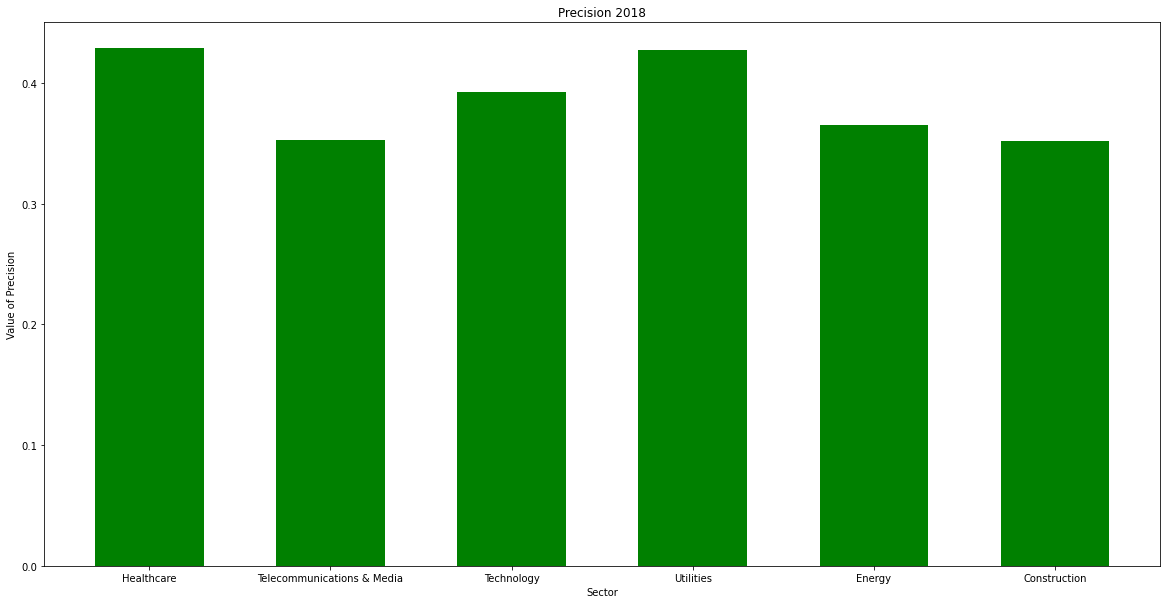

In [93]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction',
         'Consumer Products & Services',
         'Industrial Products & Services',
         'Property',
         'Transportation & Logistics',
         'Finance Services',
         'Plantation'
]

save=[]
name_sector=[]
for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2018)
    save.append(avg_3)
    name_sector.append(sector)
    print('############################## DONE #################################')



plt.figure(figsize=(20,10))
plt.title('Precision {}'.format(start_y))
plt.xlabel('Sector')
plt.ylabel('Value of Precision')

plt.bar(name_sector,save,0.6,color='g')